In [46]:
#imports
import os
import json
import itertools
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,confusion_matrix
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from callables import prepare_dataset
from callables import process_dataset
from callables import model_build
from callables import plot_roc_curve, plot_confusion_matrix, plot_feature_importnaces, find_max_fscore 
#params
filepath_input = '/Users/cotangentofzero/Data_science/Students/done/Ivan/prod/data/raw_data/'
model_name = "/Users/cotangentofzero/Data_science/Students/done/Ivan/prod/artifacts/trading_model_2"
shift = -9
anomaly_crtiretion = 1.0030

In [47]:
#callables
df = prepare_dataset(filepath_input)
df_event, df_proc = process_dataset(df, shift, anomaly_crtiretion)
data = df_proc.drop(['t_start', 't_end'], axis = 1)

100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


In [48]:
#split
train, test = train_test_split(data, test_size = 0.2, random_state = 42, shuffle = False)

x_train = train.drop('target', axis = 1)
y_train = train.target.astype(int)

x_test = test.drop('target', axis = 1)
y_test = test.target.astype(int)

#fit best model
params = {
    'iterations': 300,
    'learning_rate': 0.03,
    'depth': 5,
    'l2_leaf_reg': 2,
    'rsm': 0.7,
    'verbose': False,
    'allow_writing_files': False,
    'random_state': 42
}
model = CatBoostClassifier(**params)
model.fit(x_train, y_train)

# predict train probabilities
y_train_pred_proba = model.predict_proba(x_train)
y_train_pred_proba = y_train_pred_proba[:, 1]

# predict test probabilities
y_test_pred_proba = model.predict_proba(x_test)
y_test_pred_proba = y_test_pred_proba[:, 1]

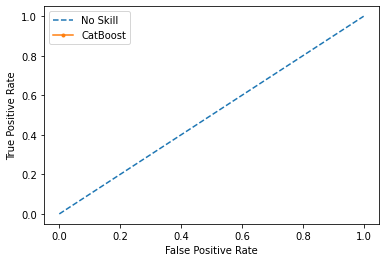

In [49]:
# plot roc curve
plot_roc_curve(y_test, y_test_pred_proba)

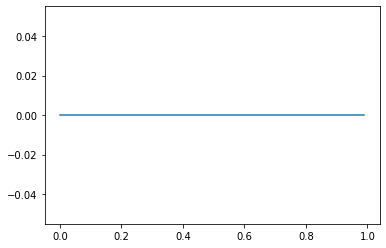

In [50]:
#plot_find_max_fscore
opt_cutoff = find_max_fscore(y_test, y_test_pred_proba)

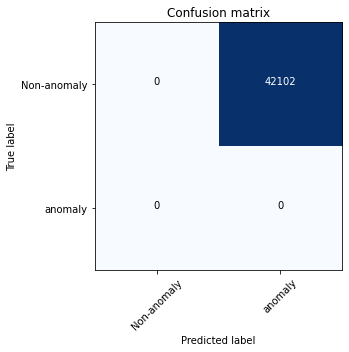

In [51]:
#plot_confusion_matrix
plot_confusion_matrix(y_test, y_test_pred_proba, opt_cutoff)

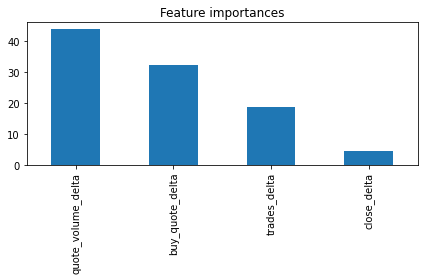

In [52]:
#plot_feature_importances
plot_feature_importnaces(model,x_train)

In [53]:
#calculate metrics
gini_train = round(100 * (2 * roc_auc_score(y_train, y_train_pred_proba) - 1),2)
gini_test  = round(100 * (2 * roc_auc_score(y_test, y_test_pred_proba) - 1),2)
f_score_train = round(100*f1_score(y_train, (y_train_pred_proba > opt_cutoff)),2)
f_score_test  = round(100*f1_score(y_test , (y_test_pred_proba  > opt_cutoff)),2)

metrics_df = pd.DataFrame({
    'gini_train' : [gini_train],
    'gini_test':[gini_test],
    'f_score_train':[f_score_train],
    'f_score_test':[f_score_test]})

display(metrics_df)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
# model.save_model(model_name)